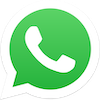

# WhatsApp Analysis

### About
Hello, I am Santiago Codaro! Below you will find code to analyze any Whatsapp group.

This notebook is divided in the following sections:<br>
1. Library Imports and file upload<br>
2. DataFrame Creation<br>
3. DF Sampling and Cleaning<br>
4. Adding more columns<br>
5. Analysis<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;a. Pivot Tables<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;b. Hour Day Heatmap<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;c. Messages per year<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;d. Messages per Sender<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;e. Word Cloud<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;f. Bar Chart Race Animation

# 1. Library imports and file upload <a name='1' />

In [31]:
import pandas as pd
import re
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from PIL import Image
import unidecode
import seaborn as sns


#### 💻 Download the Whatsapp group

The only thing outside this code you have to do is to donwload your whatsapp group.

To do so, open whatsapp --> Open the desired group --> go to Settings and scroll down --> "Export Chat" (without media) --> Send it to your computer and save it.

In [71]:
file_location = 'chat_example.txt' #in my terminal I have already specified the cwd 
                                   #so I didn't have to specify the whole path. reference: https://www.youtube.com/watch?v=ZyhVh-qRZPA&list=PL-osiE80TeTsWmV9i9c58mdDCSskIFdDS&index=2
with open(file_location) as f:
  data = f.read()
  data = ' '.join(data.split('\n'))

data[0:300] #preview the data

'[28/05/2017 20:15:32] \u200eMale D. created group “Grupo” [28/05/2017 20:15:32] \u200eMale D. added you [28/05/2017 20:15:58] Male D.: El nombre del grupo puede modificarse pero es un temonnn 😍 [28/05/2017 20:16:09] Male D.: Me parecia q no podiamos no tener grupo [28/05/2017 20:20:45] Nico: muy de acuerdo en'

# DataFrame creation <a name='2' />

In [72]:
#timestamps are the delimeters as the are enclosed in brackets and always have betweem 17 and 19 characters inside.
#Create a list of all the timestamps
time_pattern = "\[[0-9]+/[0-9]+/[0-9]+\s[0-9]+:[0-9]+:[0-9]+\]"
time = re.findall(time_pattern, data) #extract the timestamps from the string variable 'data'
time[0:5]

['[28/05/2017 20:15:32]',
 '[28/05/2017 20:15:32]',
 '[28/05/2017 20:15:58]',
 '[28/05/2017 20:16:09]',
 '[28/05/2017 20:20:45]']

In [64]:
#Create a list using the tiemstamps as delimeter, keeping the sender + the msj as each item of the list
#this list is going to work as auxiliar for the next cell.

sender_and_msj = re.split(time_pattern, data)[1:]

In [75]:
# separate sender and msj from the previous auxiliar list.

sender = []
msj = []

for i in sender_and_msj:
    if ":" in i:
        sender_index = i.find(":") #esto te devuelve la posición en la que esta el ':', por ejemplo, 10.
        sender.append(  i[0:sender_index]  )
        msj.append(i[sender_index+1:])
    else:
        sender.append("Notification")
        msj.append(i)
        
sender[0:5] #preview

['Notification', 'Notification', ' Male D.', ' Male D.', ' Nico']

In [76]:
#now we have our 3 lists: time, sender and msj. Let's merge them into a data frame.
df = pd.DataFrame({'Timestamp':time, 'Sender':sender, 'Message':msj})
df[0:5]

,Timestamp,Sender,Message
0,[28/05/2017 20:15:32],Notification,‎Male D. created group “Grupo”
1,[28/05/2017 20:15:32],Notification,‎Male D. added you
2,[28/05/2017 20:15:58],Male D.,El nombre del grupo puede modificarse pero es...
3,[28/05/2017 20:16:09],Male D.,Me parecia q no podiamos no tener grupo
4,[28/05/2017 20:20:45],Nico,muy de acuerdo en grupo y nombre 👍🏽👍🏽👍🏽👍🏽


# DF sampling and cleaning <a name='3' />

In [38]:
#Lets see the unique senders
df['Sender'].value_counts()

 Barbi          5241
 Male D.        4632
 Male M.        3781
 Mar            3035
 Nico           2924
 Santiago       1032
 Naza            159
Notification      18
 Grupo             1
Name: Sender, dtype: int64

In [39]:
df['Message']

0                          ‎Male D. created group “Grupo” 
1                                      ‎Male D. added you 
2         El nombre del grupo puede modificarse pero es...
3                 Me parecia q no podiamos no tener grupo 
4               muy de acuerdo en grupo y nombre 👍🏽👍🏽👍🏽👍🏽 
                               ...                        
20818     Porq muchas clases del profesorado se dan en ...
20819                                             VAMOOOO 
20820     Y estoy inscripta en el prof desde el 2020 pe...
20821                                                 Jjj 
20822                              Cierto q se cursa ahí! 
Name: Message, Length: 20823, dtype: object

In [40]:
#Delete mssj from sender "Grupo"
#reference: https://www.shanelynn.ie/pandas-drop-delete-dataframe-rows-columns/

fernet_msj = df['Sender'].str.contains('Grupo')
df.drop(index=df[fernet_msj].index, inplace=True)

In [41]:
#delete 'Notification' msjs
#this cell and the above are two different ways of removing rows

exclude_notifications = ~df['Sender'].str.contains('Notification')
df = df.loc[exclude_notifications]
df.value_counts('Sender')

#Now we have a clean Sender column


Sender
 Barbi       5241
 Male D.     4632
 Male M.     3781
 Mar         3035
 Nico        2924
 Santiago    1032
 Naza         159
dtype: int64

In [77]:
# non text media is represented with the labels below
df = df.applymap(str.strip) #trim all values in dataframe
df[df['Message'].str.contains('omitted')].value_counts('Message')[0:10]

Message
‎audio omitted           387
‎image omitted           365
‎image omitted ‎         204
‎sticker omitted         203
‎sticker omitted ‎        84
‎audio omitted ‎          43
‎video omitted            23
‎GIF omitted              11
‎video omitted ‎           9
‎Contact card omitted      3
dtype: int64

In [43]:
#In the cell above, despite displaying unique values, there are still duplicates.
#the following code will display the values inside an array with no formatting.
#the unicode character '\u200e was found' so it has to be removed to:

df['Message'] = df['Message'].str.replace('\u200e','',regex=False)
df = df.applymap(str.strip)

ommitted_filt = df['Message'].str.contains('omitted',regex=False) 
df.loc[ommitted_filt]['Message'].unique()

array(['image omitted', 'audio omitted', 'GIF omitted', 'video omitted',
       'Documento sin título.docx document omitted',
       'Proyecto Protocolo.docx document omitted',
       'Programa Educacional Eurasquin.pdf • 14 pages document omitted',
       'sticker omitted', 'Contact card omitted',
       'Hamburgueria product image omitted',
       'Vanguard product image omitted', 'Pizzas product image omitted',
       'Churrasco product image omitted',
       'Lineamientos para la construccion del plan de tesina.doc document omitted',
       '371142960-2876.pdf • 41 pages document omitted',
       'comprobante_TransferenciaInmediata-20210923134308332.pdf • 1 page document omitted',
       'mercadopago_withdraw-17833123832.pdf • 1 page document omitted',
       'comprobante_TransferenciaInmediata-20211029115918565.pdf • 1 page document omitted',
       'mercadopago_withdraw-19846016873.pdf • 1 page document omitted',
       'mercadopago_withdraw-20844722206.pdf • 1 page document omi

In [44]:
#now we have a clean 'Message' column:
df['Message'].value_counts().head()

image omitted      569
audio omitted      430
sticker omitted    287
Dale                78
Jajajaja            76
Name: Message, dtype: int64

# Creating more useful columns <a name='4' />

Before analyzing the data, new time columns are going to be created to filter ease the filter
of data in the future. Also, a 'Type of Message' column is going to be added to identify if the msg contains text, image, audio, etc.

#### Convert Timestamps to date type

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20804 entries, 2 to 20822
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Timestamp  20804 non-null  object
 1   Sender     20804 non-null  object
 2   Message    20804 non-null  object
dtypes: object(3)
memory usage: 650.1+ KB


In [46]:
#Remove brackets
df['Timestamp'].replace('\[|\]','',regex=True, inplace=True)
df['Timestamp'].sample(10)

5341     06/05/2018 02:06:04
11380    19/02/2020 04:19:16
17991    15/10/2021 15:38:43
19104    20/12/2021 23:21:38
1186     12/10/2017 03:51:31
58       08/06/2017 18:58:03
1647     22/11/2017 17:18:44
6972     02/08/2018 04:29:56
15089    06/02/2021 00:08:48
17705    04/10/2021 00:33:53
Name: Timestamp, dtype: object

In [47]:
#Add day and time columns
date_and_time = df['Timestamp'].str.split(' ',expand=True)
df[['Day','Time']] = date_and_time
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20804 entries, 2 to 20822
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Timestamp  20804 non-null  object
 1   Sender     20804 non-null  object
 2   Message    20804 non-null  object
 3   Day        20804 non-null  object
 4   Time       20804 non-null  object
dtypes: object(5)
memory usage: 975.2+ KB


In [48]:
#Convert date series (currently strings) to date types
df['Timestamp'] = pd.to_datetime(df['Timestamp'] , format = '%d/%m/%Y %H:%M:%S')
df['Day'] = pd.to_datetime(df['Day'] , format = '%d/%m/%Y')
df['Time'] = pd.to_datetime(df['Time'] , format = '%H:%M:%S')

# Add more granular date related columns
df['Year'] = df['Timestamp'].dt.to_period('Y')
df['Month'] = df['Timestamp'].dt.to_period('M')
df['Week'] = df['Timestamp'].dt.to_period('W')

In [79]:
#preview
df[-5:]


,Timestamp,Sender,Message
20818,[01/04/2022 16:14:38],Male D.,Porq muchas clases del profesorado se dan en e...
20819,[01/04/2022 16:14:42],Male D.,VAMOOOO
20820,[01/04/2022 16:15:14],Male D.,Y estoy inscripta en el prof desde el 2020 per...
20821,[01/04/2022 16:23:25],Barbi,Jjj
20822,[01/04/2022 16:23:35],Barbi,Cierto q se cursa ahí!


# Analysis <a name='5' />

#### Pivot Tables

In [53]:
#Amount of messages by year and sender

table = pd.pivot_table(df,index='Year',columns='Sender', values='Message', aggfunc='count', 
                       margins=True)

table

Sender,Barbi,Male D.,Male M.,Mar,Naza,Nico,Santiago,All
Year,,,,,,,,
2017,491.0,584.0,449.0,410.0,100.0,313.0,192.0,2539
2018,1361.0,1594.0,1549.0,960.0,8.0,757.0,279.0,6508
2019,461.0,436.0,503.0,360.0,10.0,257.0,97.0,2124
2020,1034.0,717.0,591.0,461.0,35.0,739.0,96.0,3673
2021,1463.0,998.0,514.0,644.0,6.0,694.0,218.0,4537
2022,431.0,303.0,175.0,200.0,NaN,164.0,150.0,1423
All,5241.0,4632.0,3781.0,3035.0,159.0,2924.0,1032.0,20804


In [54]:
#Pivot with share % of messages by sender (meaning that each columns sums 100%)

table3 = pd.crosstab(df.Year,df.Sender,values=df.Message,aggfunc='count',
           normalize='columns',margins=True).mul(100).round(2).astype(str).applymap(lambda x: str(x)+"%")

#create list to sort/order table3 in desc. order
list_sender_desc = df['Sender'].value_counts().index.values.tolist()
list_sender_desc.insert(0,'All')
table3 = table3.reindex(columns=list_sender_desc)

table3

Sender,All,Barbi,Male D.,Male M.,Mar,Nico,Santiago,Naza
Year,,,,,,,,
2017,12.2%,9.37%,12.61%,11.88%,13.51%,10.7%,18.6%,62.89%
2018,31.28%,25.97%,34.41%,40.97%,31.63%,25.89%,27.03%,5.03%
2019,10.21%,8.8%,9.41%,13.3%,11.86%,8.79%,9.4%,6.29%
2020,17.66%,19.73%,15.48%,15.63%,15.19%,25.27%,9.3%,22.01%
2021,21.81%,27.91%,21.55%,13.59%,21.22%,23.73%,21.12%,3.77%
2022,6.84%,8.22%,6.54%,4.63%,6.59%,5.61%,14.53%,0.0%


In [55]:
#Don't pay attention to this pls I am just reindexing the df.
df.reset_index(inplace=True)
df.drop(labels=['index'], axis=1,inplace=True)


## Hour-Day Heatmap

It will help visualize the day and the hour with more message traffic.

In [56]:
#first I have to create day of the week column and hour od the day column
df['Day of Week'] = df['Day'].dt.day_name()
df['Hour Bucket'] = df['Timestamp'].dt.hour

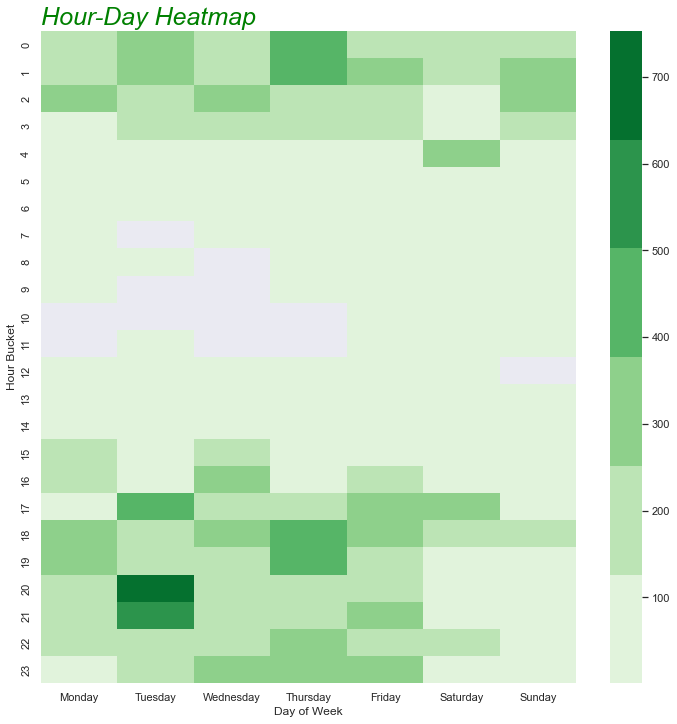

In [57]:
# Let's create a df that has the days of the week as columns and the hour bucket as rows.
time_day_df =  pd.pivot_table(df, index='Hour Bucket', columns='Day of Week', values='Message', aggfunc = 'count')

#reorder the columns
time_day_df = time_day_df.reindex(columns=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

#Heatmap parameters
colormap = sns.color_palette("Greens")
sns.heatmap(time_day_df,cmap=colormap,linewidths=0 , linecolor='grey')

#Config plot
plt.title("Hour-Day Heatmap", fontsize=25, fontweight=0, color='green', loc='left', style='italic')
plt.show()

#plt.savefig('heatmap no grid.png')

In [80]:
# Create a column to only count the first message,
    #this way, we are avoiding over counting people that sends many messages one after another.
    
df['Count Message'] = pd.Series().view('int64')

for i in range(1,len(df['Sender'])):
    df.at[0,'Count Message'] = 1
    val = df['Sender'].iloc[i]
    if df['Sender'].iloc[i] == df['Sender'].iloc[i-1] :
        df.at[i,'Count Message'] = 0
    else:
        df.at[i,'Count Message'] = 1
        
df[-5:]

/var/folders/f0/g1j_qdv5445dsvfg20hql4rm0000gn/T/ipykernel_26331/1075890152.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df['Count Message'] = pd.Series().view('int64')


,Timestamp,Sender,Message,Count Message
20818,[01/04/2022 16:14:38],Male D.,Porq muchas clases del profesorado se dan en e...,0.0
20819,[01/04/2022 16:14:42],Male D.,VAMOOOO,0.0
20820,[01/04/2022 16:15:14],Male D.,Y estoy inscripta en el prof desde el 2020 per...,0.0
20821,[01/04/2022 16:23:25],Barbi,Jjj,1.0
20822,[01/04/2022 16:23:35],Barbi,Cierto q se cursa ahí!,0.0


In [59]:
#Create an auxiliar list to sort values in the next cell

test1 = pd.pivot_table(df,index='Sender', values='Count Message', aggfunc='sum', 
                       margins=True) #.div(len(df['Sender'].index)).mul(100).round(2).astype(str).applymap(lambda x: str(x)+"%")
test1.sort_values('Count Message',ascending=False, inplace=True)
test1.drop(labels=['All'], axis=0,inplace=True)

desc_sort_sum_count_message = test1.index.values.tolist()



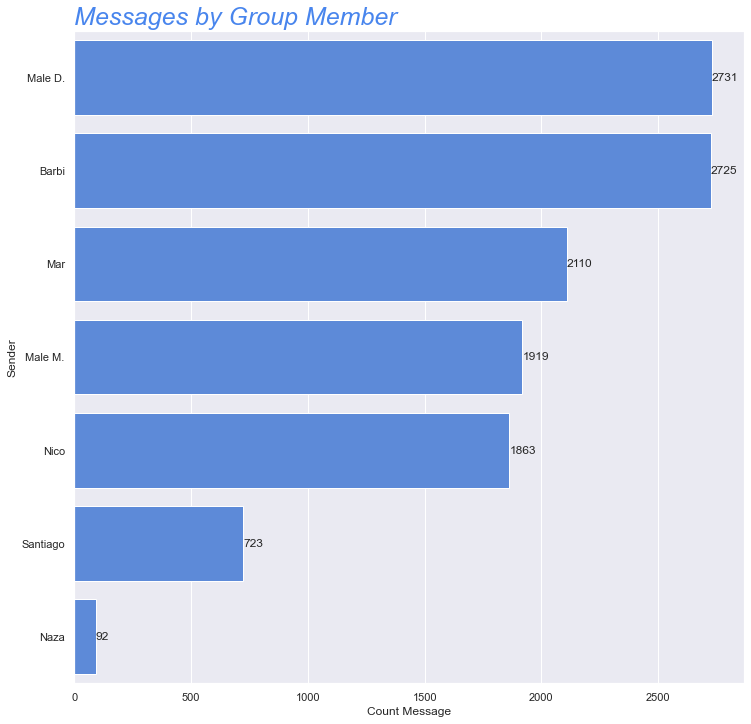

In [60]:
#Bar chart with messages by sender

sns.set(rc = {'figure.figsize':(12,12)})
#clrs = ['grey' if (x < max(test1['Count Message'])) else 'red' for x in test1['Count Message'] ] way of setting diferent colors
# who v/s fare barplot
ax = sns.barplot(x = 'Count Message',
            y = 'Sender',
            ci=None, 
            estimator=sum,
            order = desc_sort_sum_count_message,
            #palette='crest_r',
            color = '#4885ed',
            data = df)

for i in ax.containers:
    ax.bar_label(i,)

#plt.xticks(rotation=45)
plt.title("Messages by Group Member", fontsize=25, fontweight=0, color='#4885ed', loc='left', style='italic')
# Show the plot
#plt.show()
plt.savefig('sender.png')

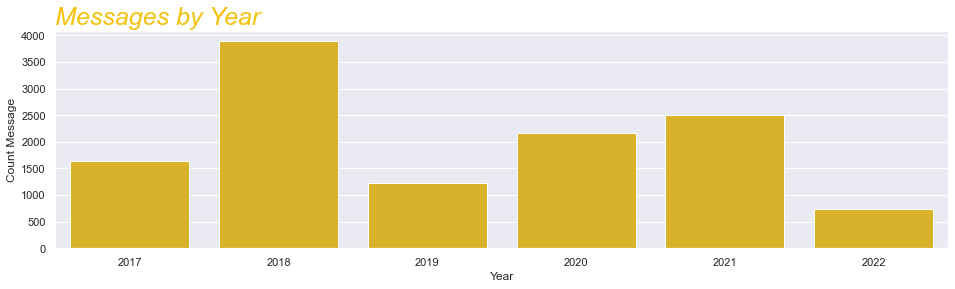

In [65]:
#Verical Bar chart with messages by year


sns.set(rc = {'figure.figsize':(16,4)})
#clrs = ['grey' if (x < max(test1['Count Message'])) else 'red' for x in test1['Count Message'] ] way of setting diferent colors
# who v/s fare barplot
sns.barplot(y = 'Count Message',
            x = 'Year',
            ci=None, 
            estimator=sum,
            #palette='crest_r',
            color = '#f4c20d',
            data = df)
plt.title("Messages by Year", fontsize=25, fontweight=0, color='#f4c20d', loc='left', style='italic')
plt.show()
#plt.savefig('year.png')

## Wordcloud

In this section a wordcloud of the column "messages" is going to be returned.

In [ ]:
#import required dependencies
#ref: https://empresas.blogthinkbig.com/pln-con-python-tokens-stop-words-y-ngrams/

import nltk
nltk.download()
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

In [66]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [67]:
#list of words to exclude from the wordcloud
exclude_words_list = [  'santi','mar' ,'nico','male','fausto','luky','mati','omitida','omitido','imagen','enzo','fau','ringo','wirchi','marto','jere','jero',
                      'tuvie','miglu','pota','turco','juampi','gianni','miglu',
                      'leon','guzzo','antes','achi','quieren','sisi','fui','entre','x','debe','hablando','hizo',
                      'pueden', 'seria','falta','esta','d',
                      'vez','jajajaj','decir','padrino','felipe','topor','topa','pipo',
                      'jueves','anda','nivel','ademas','cosas','iba','da','queres','quedo','sii','cada','tmb',
                      'mira', 'podes','dije','mucha','otra','jajajajajaja','desp','somos','pone','auto','hacemos',
                      'llevo','tampoco','algun','sacar','lado','yendo','cualquier','arriba','dije','despue','despues',
                      'nadie','estamos','this','message','was','deleted','soy','final','cual','listo','entonce',
                      'digo','dice','tarde','entiendo','tanto','nunca','vi','manana','obvio','ante','quiere',
                      'cuanto','tenia','sin','estamo','tambien','van','hora','tas','veo','viene','jajaj','nose',
                      'cosa','ah','dijo','tipo','ayer','siempre',
                      'hasta','jajajajaja','sabe','vas','paso','sino','toda','desde','ta','mismo',
                      'tener','tienen', 'pasa', 'dia','alguna','gente','sea','dan','estar','pido','mejor','parece',
                      'era','re','total','esas','todavia','nono','poner','quienes',
                      'sos','van''jajajajaja','uno','quiero','aca','estaba','10','dos','que',
                      'de','la','a','no','mi','yo','comigo','tu','con','vos','ti','el','ella','ello','usted',
                      'nosotros','nostras','ellas','ellos','ustedes','lo','la','le','se','nos','me','te','se',
                      'suyo','y','omitted','en','es','un','si','para','image','por','los','una',
                      'pero','las','hay','como','audio','del','al','ya','o','mas','estoy','eso','muy',
                      'hoy','todo','toy','porque','tiene','igual','q','va','voy','todos','jajaja','sticker',
                      'bien','mal','tengo','son','alguno','video','este','ahora','nada','creo','bueno','dale',
                      'jaja','Frequency','hace','che','2','ese','esto','ver','algo','más','3','ir','fue',
                      'cuando','mierda','gif','puede','esa','vamos','jajajaja','ahi','ser','1','ni','puedo',
                      'asi','claro','hacer','alguien','eh','mañana','donde','quien','tenes','5','estan',
                      'qué','solo','estas','mucho','casa','4','otro','les','su']

In [69]:
#create a string variable that merges all the records from the Message column. It will feed the Word Cloud

df["Message Aux"] = df['Message'].copy().str.lower().str.replace('[^\w\s]','',regex=True).apply(lambda x: unidecode.unidecode(x)).copy() #remove punctuation
aux1 = df["Message Aux"].copy().str.split(expand=True).stack()
message_string = ' '.join(aux1)       

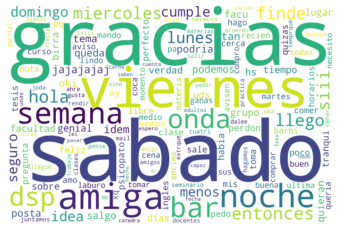

In [70]:
#ref: https://www.youtube.com/watch?v=eHxWshJpoRk

#appearance
wc = WordCloud(background_color="white", stopwords=exclude_words_list, height=2000, width=3000,
               normalize_plurals = False, collocations = False, max_words = 150 )
wc.generate(message_string)

#plotting
plt.imshow(wc,interpolation = 'bilinear')
#plt.title( ('@'+'MDBp'), fontsize=40, pad=22, color='Black')
plt.axis('off')
plt.grid(False)
plt.show()


In [ ]:
wc.to_file('Wordcloud.png') #in case you want to save it

## Bar Chart Race Animation

The tool Flourish was used to create this animation: https://public.flourish.studio/visualisation/9267728/ <br>
Please find below the code to create a ready to use template.

In [62]:
#Export for bar chart race in flourish to excel
pt_senders_month = pd.pivot_table(df, index='Sender', columns='Month', values='Count Message',
                                  aggfunc='sum', fill_value = 0 )

pt_senders_month = pt_senders_month.cumsum(axis=1) #cumulative
pt_senders_month

Month,2017-05,2017-06,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,...,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04
Sender,,,,,,,,,,,,,,,,,,,,,
Barbi,6,15,119,150,197,254,302,333,388,490,...,2107,2119,2210,2336,2431,2524,2592,2652,2722,2725
Male D.,10,25,96,106,186,269,359,435,568,716,...,2211,2225,2319,2432,2494,2557,2606,2670,2729,2731
Male M.,3,14,72,89,145,223,280,319,380,447,...,1760,1764,1814,1828,1846,1865,1877,1883,1919,1919
Mar,6,18,90,129,188,244,289,336,400,498,...,1696,1701,1793,1886,1922,1979,2044,2073,2110,2110
Naza,4,8,44,50,53,60,60,60,60,60,...,88,88,90,90,92,92,92,92,92,92
Nico,2,9,51,82,103,170,214,224,275,334,...,1572,1577,1635,1703,1761,1792,1822,1845,1863,1863
Santiago,8,15,28,51,85,114,139,143,174,188,...,508,509,547,578,596,620,653,679,723,723


In [63]:
#save it
pt_senders_month.to_excel(r'/Users/santiagocodaro/Code/Whatsapp Project/floursih template for linkedin post.xlsx',
                        index= True, header=True)